In [1]:
import warnings
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("../data/large_email_dataset.csv")
data[ data["label"] == "job_applicant"].head()

,text,label
9825,"Dear Hiring Manager,\n\nI am writing to expres...",job_applicant
9826,"Dear Hiring Manager,\n\nI am writing to expres...",job_applicant
9827,"To the Hiring Team at NextGen Ltd,\n\nHaving f...",job_applicant
9828,"Dear Hiring Manager,\n\nI am writing to expres...",job_applicant
9829,"Dear Hiring Manager,\n\nI am writing to expres...",job_applicant


In [3]:
train_df , test_df = train_test_split (
        data , 
        test_size = 0.2 , 
        random_state = 42 , 
        stratify = data["label"] 
    )

In [136]:
class_counts  = train_df["label"].value_counts()

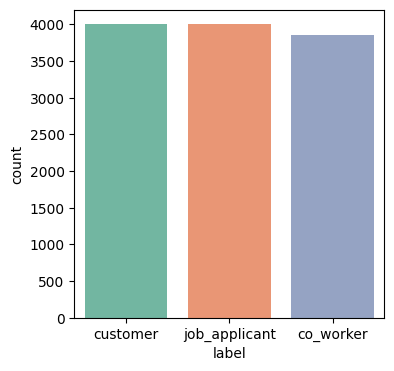

In [5]:
plt.figure(figsize = (4, 4 ) )
sns.countplot( data = train_df ,  x = "label" , order = class_counts.index , palette = "Set2")
plt.show()

In [6]:
import re

def tokenizer(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r',' , ' ' , text)
    text = re.sub(r'\.' , ' ' , text ) 
    text = re.sub(r'-' , ' ' , text ) 
    return text


In [7]:
train_df["clean_text"] = train_df["text"].apply(tokenizer)

In [8]:
label_mapping = {
    "customer" : 0 , 
    "co_worker" : 1 ,
    "job_applicant" : 2
}

train_df["label_encoding"] = train_df["label"].map(label_mapping)

In [9]:
test_df["clean_text"] = test_df["text"].apply(tokenizer)
test_df["label_encoding"]  = test_df["label"].map(label_mapping)

In [10]:
test_df

,text,label,clean_text,label_encoding
14120,"Dear Hiring Manager,\n\nMy passion for graphic...",job_applicant,dear hiring manager my passion for graphic d...,2
11693,"Dear Hiring Manager,\n\nI am writing to expres...",job_applicant,dear hiring manager i am writing to express ...,2
12831,"To the Hiring Team at Solutions Inc,\n\nHaving...",job_applicant,to the hiring team at solutions inc having f...,2
1209,"Hi,\n\nI saw X100 Widget on your website. Coul...",customer,hi i saw x100 widget on your website could ...,0
11847,"To the Hiring Team at Global Tech,\n\nHaving f...",job_applicant,to the hiring team at global tech having fol...,2
...,...,...,...,...
4949,"Hello,\n\nThe X100 Widget I purchased on 2/12/...",customer,hello the x100 widget i purchased on 2/12/20...,0
7327,"Hello Taylor,\n\nQuick question about the remo...",co_worker,hello taylor quick question about the remote...,1
14455,"To the Hiring Team at Synergy Systems,\n\nHavi...",job_applicant,to the hiring team at synergy systems having...,2
6944,"Hi all,\n\nQuick update on Client Onboarding P...",co_worker,hi all quick update on client onboarding pro...,1


In [11]:
X = train_df["clean_text"]
y = train_df["label"]

In [12]:
X_train , X_test , y_train , y_test = train_test_split ( 
    X , 
    y , 
    test_size = 0.3 , 
    random_state = 42 ,
    stratify = y )

In [39]:
tfidf_vectorizer = TfidfVectorizer(
    max_features = 10 , 
    ngram_range = ( 1 , 2 ),
    stop_words = "english"
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_text"])



In [40]:
from sklearn.naive_bayes import MultinomialNB


model = LogisticRegression(max_iter=1000 , verbose = 2)
model.fit(X_train_tfidf, y_train)
logistic_score = model.score(X_val_tfidf , y_test)

model_1 = MultinomialNB( )
model_1.fit(X_train_tfidf , y_train)
naive_score = model_1.score(X_val_tfidf , y_test)

print (f"LogisticRegression Score is {logistic_score * 100: .2f} %")
print (f"naive bayes score is        {naive_score * 100: .2f} %") 

LogisticRegression Score is  91.93 %
naive bayes score is         79.76 %


In [41]:
y_pred = model.predict(X_val_tfidf)


In [42]:
def predict(text):
    text = tokenizer(text)
    text_idf = tfidf_vectorizer.transform([text])
    return model.predict(text_idf)

In [43]:
text = """
    Dear Hiring Manager
    name is abdelmoughit EL Ouaad , I am a student at FSTM
    i want to express my interest for data science postion
"""
predict(text)[0]

'job_applicant'

In [50]:
text = """
    Dear Hiring Manager
    name is abdelmoughit EL Ouaad , I am a student a FSTM
    i want to express my interest for data science postion
    project project project project project meeting 
"""
predict(text)[0]

'job_applicant'

<Figure size 300x300 with 0 Axes>

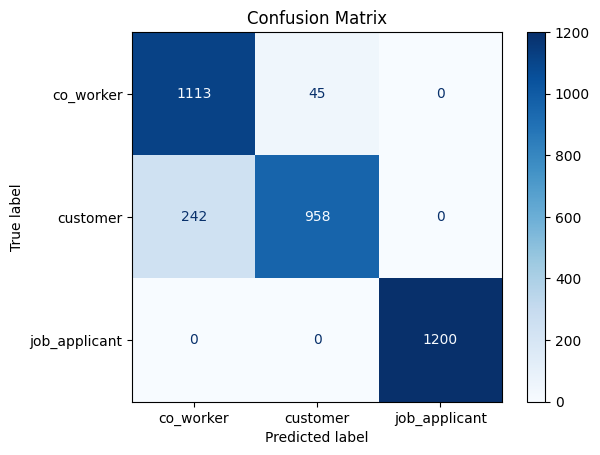

In [51]:
cm = confusion_matrix (y_test , y_pred , labels = model.classes_ )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
plt.figure(figsize = (3 , 3))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

    co_worker       0.82      0.96      0.89      1158
     customer       0.96      0.80      0.87      1200
job_applicant       1.00      1.00      1.00      1200

     accuracy                           0.92      3558
    macro avg       0.93      0.92      0.92      3558
 weighted avg       0.93      0.92      0.92      3558



In [139]:
y_binary = label_binarize(y_test , classes = model.classes_)

In [152]:
print (f"the three classes are {model.classes_}")
print ( y_test ) 
print ("\n\n")
print ("make y_test in binary way ")
print ( "the label_binaryze\n" ,y_binary )


the three classes are ['co_worker' 'customer' 'job_applicant']
9818         co_worker
12262    job_applicant
8630         co_worker
313           customer
13801    job_applicant
             ...      
9204         co_worker
6629         co_worker
5900         co_worker
11555    job_applicant
2540          customer
Name: label, Length: 3558, dtype: object



make y_test in binary way 
the label_binaryze
 [[1 0 0]
 [0 0 1]
 [1 0 0]
 ...
 [1 0 0]
 [0 0 1]
 [0 1 0]]


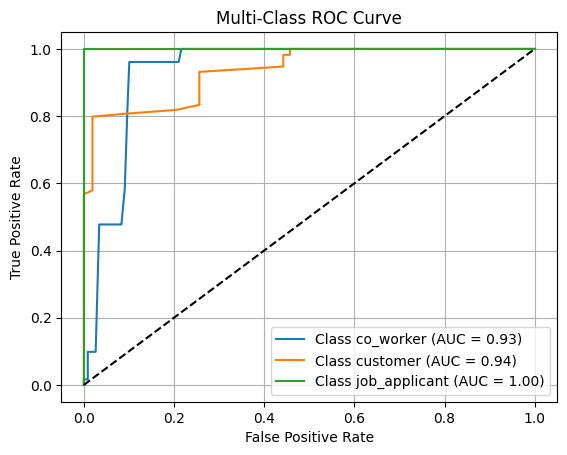

<Figure size 1000x800 with 0 Axes>

In [157]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

classes = model.classes_  
y_test_bin = label_binarize(y_test, classes=classes) #[customer] -> [0 , 1 , 0] ||| co_worker -> [1 , 0 , 0]
y_score = model.predict_proba(X_val_tfidf)


fpr = dict()
tpr = dict()
roc_auc = dict()
tresh_hold_counter = 0 
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i],drop_intermediate=False)
    tresh_hold_counter = len(_)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})" ,)

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.figure(figsize = (10 , 8 ) )

plt.show()


Class co_worker: 100000 thresholds tested
Class customer: 100000 thresholds tested
Class job_applicant: 100000 thresholds tested


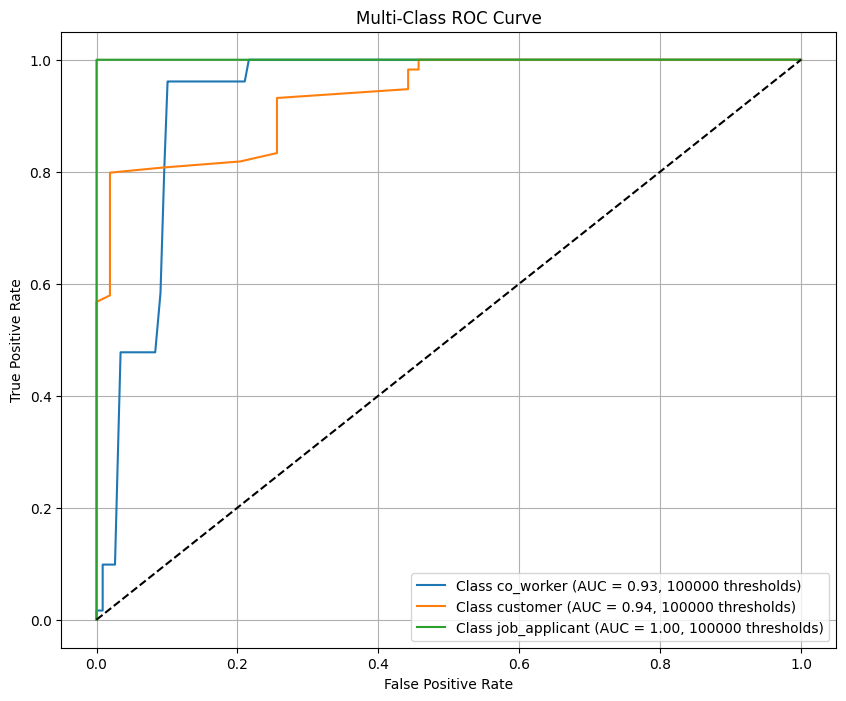

In [155]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
thresholds = dict()

for i in range(len(classes)):
    # Create a custom array of thresholds (e.g., 1000 thresholds between 0 and 1)
    custom_thresholds = np.linspace(0, 1, 100000)
    
    # Calculate FPR and TPR for each threshold manually
    fpr[i] = []
    tpr[i] = []
    
    for threshold in custom_thresholds:
        # Create binary predictions based on threshold
        y_pred = (y_score[:, i] >= threshold).astype(int)
        
        # Calculate true positives, false positives, true negatives, false negatives
        tp = np.sum((y_pred == 1) & (y_test_bin[:, i] == 1))
        fp = np.sum((y_pred == 1) & (y_test_bin[:, i] == 0))
        tn = np.sum((y_pred == 0) & (y_test_bin[:, i] == 0))
        fn = np.sum((y_pred == 0) & (y_test_bin[:, i] == 1))
        
        # Calculate TPR and FPR
        tpr_value = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        tpr[i].append(tpr_value)
        fpr[i].append(fpr_value)
    
    # Convert to numpy arrays
    fpr[i] = np.array(fpr[i])
    tpr[i] = np.array(tpr[i])
    thresholds[i] = custom_thresholds
    
    # Calculate AUC
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Class {classes[i]}: {len(custom_thresholds)} thresholds tested")

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f}, {len(thresholds[i])} thresholds)")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()